In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import time
import os
import imageio.v2
import numba as nb
from scipy import fft
from IPython.display import display, clear_output
from datetime import datetime
import re

# N-BODY PROJECT

The code block below is used to plot the density of the particles at a given step. The make_nbody_gif functions makes a gif by compiling the successive heatmap of the particles at every some parameter (osamp) step.

In [311]:
#making plot functions

def plot_nbody(particles,savepath=None,niter=None):
    if niter is not None:
        name_im=savepath+'/step'+str(niter)

    fig=plt.figure()
    fig.set_size_inches([8.5,8.5])
    plt.imshow(parts.density[:parts.ngrid,:parts.ngrid]**0.5,cmap="inferno") #the squareroot is for better resolution
    if niter is not None:
        plt.savefig(name_im,bbox_inches='tight')
        plt.close()

#borrowed code: https://stackoverflow.com/questions/5967500/how-to-correctly-sort-a-string-with-a-number-inside
def atoi(text): 
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]
#end of borrowed code

def make_nbody_gif(particles,ntakestep,dt=0.008,timer=True,osamp=5):
    date=datetime.now().strftime("%Y_%m_%d")
    simpath='Figures/Sim_for_{}_steps_{}/'.format(ntakestep,date)
    try:
        os.makedirs(simpath)
    except:
        None
    plt.clf()
    plt.ioff()
    particles.get_density() #at step zero, we get the initial density of the particles
    plot_nbody(particles,simpath,0)
    
    for i in tqdm(range(ntakestep)): #taking a step until we reach the number of steps we want
        
        for j in range(osamp): #we do this so that the gif "moves faster" so in total nsteps=ntakestep*osamp
            t1=time.time()
            particles.take_step(dt)
            if timer and j==0 and i==0:
                t2=time.time()
                timing=t2-t1
                del t2,t1
        if i==0:
            print('For {} particles with with time step {} s, taking a step takes {} s'.format(particles.nparticle,dt,timing))
        plot_nbody(particles,simpath,i+1) #call the plotting function
        plt.close()
    
    all_im=[]
    filenames=os.listdir(simpath)
    filenames.sort(key=natural_keys) #sorting with natural keys each image to make the gif (to make sure we 
                                                        #superpose step0,step1....stepn-1,stepn in order)

    for fn in filenames:
        all_im.append(imageio.v2.imread(simpath+fn))
    imageio.v2.mimsave(simpath+'Simulation.gif', all_im) #this is the gif
    plt.ion()

        

Note: My n-body code is closely inspired from jon's code but I made sure to code and understand each part so I will give a description of the functions and the structure of the code in the following text blocks.

The goal of the n-body project is to make computer simulations of the dominating force in the universe, gravity, acting on many particles. Here, we make the simplest assumptions that the system, made of particle masses, only interact with each other through gravity. 

For each particles, we have a mass, a position and a velocity. We want to update the position and the velocity after some time $\delta t$. To get a higher order accuracy, we assume that the positions and velocities are half a step out of sync. This means that the velocity is the average velocity over the position time step and the position is the average position over the next velocity timestep. This is the leapfrog method, and we have the system of equations:

$x_i(t+\delta t)=x_i(t)+v_i(t+\frac{\delta t}{2})*\delta t$

$v_i(t+\frac{\delta t}{2})=v_i(t-\frac{\delta t}{2})+a_i(t)*\delta t$,

Where $x_i(t)$/$v_i(t)$/$a_i(t)$ is the position/velocity/acceleration or the $i^{th}$ particle at time $t$. By Newton's second law, the acceleration is given by the net force acting on the particle. With our simplified assumptions, this is simply the sum of the gravitational forces from all the other particles acting on a particle $i$. By taking small time steps, the solutions should be accurate enough.


### On the calculation of the Forces:

1. Because the gravitational force is proportional to $\frac{r}{|r|^3}$, if the particles come very close together the force blows up which is not what we want. We want the forces to drop to zero when particles are very close together. We can use a softening method to implement this:

    We let the force be proportional to $\frac{r}{(r^2+\epsilon^2)^{3/2}}$ such that when $r \rightarrow 0$, $F\rightarrow 0$ but remains ~$\frac{r}{|r|^3}$ for large distances. So, we have a softening parameter $\epsilon$ when we compute the forces in the simulation. This is call *softening*.
    

2. The gravitational force between two particles is given by $-\frac{Gm_1m_2}{r_{12}^2}$, but since we want the acceleration of say $m1$, then we want $-\frac{Gm_2}{r_{12}^2}$. Because the gravitational force is conservative, we know it can be written as a gradient of potential. So, for two particles we can compute the potential $\frac{Gm_2}{r_{12}}$, and take the gradient of that instead of computing the force directly. For a field of particles, define $P(r)$ as the potential from all particles acting on one particle. Then, we have a potential field given by $\int P(r-r')\rho(r)d^2r$, with $\rho(r)$ being the density field. So, we have a convolution that can be solved in Fourier space to get the potential field and from that we can get the force/acceleration field by taking the gradient!


## Class Particles Functions:
(The rk4 conditions in some of the class functions are there to not "save" the trial values in the class and instead return the trial values (density,potential,force,position...) to some other function.)

Note: The purpose of having outside functions is to call numba which makes the code run a lot faster.

##### get_initconditions(self): 
We have 4 different type of initial conditions: uniform, one gaussian cluster, two gaussian clusters, and one particle per grid cell. For all four methods, we scale the positions in the range of the number of grid that we have have shift them by $\frac{1}{2}$. 

##### get_density(self,rk4=False,trialpos=None,trialdensity=None,trialm=None):
Before calling the outside-class function get_heatmap(), we want to check the positions of the particles depending on if we are in periodic or non-periodic mode. 
* Periodic mode:
    We want the particles whose new positions are outside of the grid, to be put back on the grid, such that particles outside the left (in $x$ or $y$) at r are now at r + ngrid, the one on the right are now at r - ngrid.
* Non Periodic mode:
    We want the particles whose new positions are outside of the grid to be "deleted". This is done by setting their masses to zero such that they won't affect the density field (thus the potential field, thus the acceleration and thus the evolution in time of the system).
    
Once the positions/masses are adjusted depending on the mode of the object Particles, we call the function get_heatmap() to compute the density. The idea is that for each particles, we find their closest grid position (i.e. int(pos-0.5)) and add their mass to the corresponding grid point. 

##### get_Vsingle(self):
We want to compute an arbitrary's particle Potential (here we chose the position centered at 0), i.e. $P(r)$. I used Jon's code to do that. In short, the function returns a matrix of $1/r$, where r is the distance between a grid cell and the center. If $r \le \epsilon$ (softening parameter), we set $1/r$ to $1/\epsilon$. So we a have softened $P(r)$ for the particle centered when we call this method.

###### get_V_Field(self,rk4=False,trialpos=None,trialdensity=None,trialm=None,trialV_Field=None):
This function computes the potential field of the particles, given the density field and $P(r)$. Like mentioned above, to get the potiential field, we use a convolution: $\int P(r-r')\rho(r)d^2r$. This is done by taking the fourier transform in 2D space of the density field and $P(r)$, multiplying the results and inverse fourier back in 2D space.

##### get_forces(self):
This function returns the forces (accelerations) of the particles and calls the outside-class function get_grad() to compute the gradient of the potential field. In the get_grad() function, we first compute the potential at the given grid cell. Since the potential field's values is given at the vertices of the grid, we want to find the gridcell in which each particle is and compute a weighted average of the potential for that particle at that gridcell position. We get the $x_0,y_0$ by taking the floor of the $x,y$ position, and $x_1,y_1$ by adding 1. Then, a way to weight the potential is to compute the areas delimited by the position of the particle in the gridcell (since the total area is 1). The below figure that I made shows which area should be used as the weight for each potential (color coded). Thus the potential of the particles is of the form:

$V = V_{00}(1-dy)(1-dx) + V_{01}(dy)(1-dx) + V_{10}(1-dy)(dx) + V_{11}(dy)(dx)$, where $dy$ and $dx$ is the distance in x and y from the grid point to the left of the particle (i.e. $(x_0,y_0)$, where $V_{00}$ is located).

Then to compute the force, we take the gradient with respect to $dx$ and $dy$, such that we have

$F_x = a_x =  -V_{00}(1-dy) - V_{01}(dy) + V_{10}(1-dy) + V_{11}(dy) =  (V_{11}-V_{01})dy + (V_{10}-V_{00})(1-dy)$ (1)

$F_y = a_y = -V_{00}(1-dx) + V_{01}(1-dx) -V_{10}(dx) + V_{11}(dx) = (V_{11}-V_{10})dx + (V_{01}-V_{00})(1-dx)$ (2)

In short, this function calls the outside function get_grad() which uses equation (1) and (2) to compute the forces/acceleration.


##### take_step(self,dt):
This is the function that makes the update/takes the step. Here, we use the leapfrog method with the equations

$x_i(t+dt)=x_i(t)+v_i(t+\delta t/2)*dt$ (3)

$v_i(t+\delta t/2)=v_i(t-\delta t/2)+a_i(t)*dt$, (4) 

Now in the code, if we view the velocity array as the velocity at time half a step out of sync ($t+\delta t/2$), we first compute the updated position with (3), then compute the forces with the updated positions, then compute the updated velocities at time $t+\delta t/2$ with equation (4). We note that this exact order is important because if not, this would not be the leapfrog method.

##### show_timer(self):
This function's purpose is simply to print the computational time of different methods.

##### get_energy(self):
This function computes the total energy of the system which is sum of the kinetic energy ($\frac{1}{2}\sum m_i v_i^2$) and the potential ($-\sum \rho_{field}*V_{field}$)

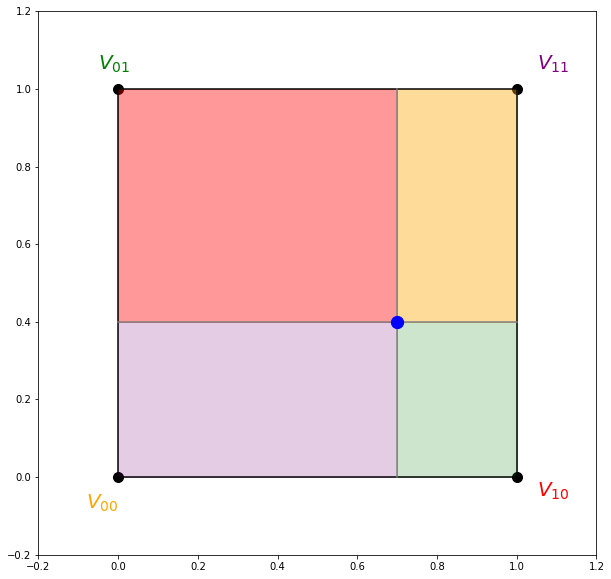

In [16]:
#numba makes the code runs wayyy faster

#outside functions
@nb.njit(parallel=True)
def inside_grid(pos,ngrid):
    for i in nb.prange(len(pos)):
        if pos[i,0]<-0.5: #x pos out of grid to the left
            pos[i,0] += ngrid
        elif pos[i,0]>=ngrid-0.5: #x pos out of gridgrid to the right
            pos[i,0] -= ngrid
        
        if pos[i,1]<-0.5: #y pos out of grid to the left
            pos[i,1] += ngrid 
        elif pos[i,1]>= ngrid-0.5: #y pos out of grid to the right
            pos[i,1] -= ngrid
    return pos
    
@nb.njit(parallel=True)
def outside_grid(pos,masses,ngrid):
    #set masses to 0 if outside of grid --> won't be taken into calculations for density/V-field thereafter
    for i in nb.prange(len(pos)):
        if pos[i,0]<-0.5: #x pos out of grid to the left
            masses[i]=0
        elif pos[i,0]>=ngrid-0.5: #x pos out of grid to the right
            masses[i]=0
        
        if pos[i,1]<-0.5: #y pos out of grid to the left
            masses[i]=0
        elif pos[i,1]>= ngrid-0.5: #y pos out of grid to the right
            masses[i]=0

    return pos
        
@nb.njit(parallel=True)
def get_heatmap(pos,masses,matdensity):
    for i in nb.prange(len(pos)):
        #add back 0.5 such that the particles at -0.5 count in the first left grid edge 
        # and those at n-0.5 count in the last grid edge --> taking int return gives the edge the left of the part
        x=int(pos[i,0]+0.5)
        y=int(pos[i,1]+0.5)
       
        if masses[i]>0: #if mass is 0 --> outside of grid so do not consider them in the density field
            matdensity[x,y] = matdensity[x,y] + masses[i]
    return matdensity

@nb.njit(parallel=True)
def get_grad(pos,Vfield,masses,ngrid,grad):
    for i in nb.prange(len(pos)):
        if masses[i]>0:
            #edge cases and defs for x
            if pos[i,0]<0:
                x0=ngrid-1
                x1=0
                dx=pos[i,0]+1
            else:
                x0=int(pos[i,0])
                dx=pos[i,0]-x0
                x1=x0+1
                if x1==ngrid:
                    x1=0

            #edge cases and defs for y
            if pos[i,1]<0:
                y0=ngrid-1
                y1=0
                dy=pos[i,1]+1
            else:
                y0=int(pos[i,1])
                dy=pos[i,1]-y0
                y1=y0+1
                if y1==ngrid:
                    y1=0   

            #compute the grads from the 4 points encircling the mass in the grid
                #x0,y0 --> V00 
                #x1,y1 --> V11
                #x0,y1 --> V01
                #x1,y0 --> V10
            grad[i,0]=(Vfield[x1,y1]-Vfield[x0,y1])*dy+(Vfield[x1,y0]-Vfield[x0,y0])*(1-dy)
            grad[i,1]=(Vfield[x1,y1]-Vfield[x1,y0])*dx+(Vfield[x0,y1]-Vfield[x0,y0])*(1-dx)
    return grad


In [307]:
#Class Particles

class Particles():
    def __init__(self,nparticle,ngrid,soft=2,periodic=True,timer=True,method="leapfrog",ics="uniform"):
        self.nparticle=nparticle #number of particles
        self.ngrid=ngrid #grid dimension is ngrid x ngrid 
        self.soft=soft #softening parameter
        self.periodic=periodic #True --> periodic mode / False --> not periodic mode
        self.timer=timer #True --> we want to compute the computational time
        self.ics=ics #initial conditions
        self.method=method #method, can either be leapfrog or rk4
        
        #initialize 
        self.m=np.ones(self.nparticle) #masses of the particles
        self.pos=np.zeros([self.nparticle,2]) #positions of the particles
        self.v=np.zeros([self.nparticle,2]) #x,y speed of the particles
        self.f=np.zeros([self.nparticle,2]) #forces/acceleration acting on the particles

        if self.periodic:
            self.density=np.zeros([self.ngrid,self.ngrid]) #density field is ngrid x ngrid dimension
            self.V_Field=np.zeros([self.ngrid,self.ngrid]) #potential field is ngrid x ngrid dimension
        else: 
            #twice as big if not periodic
            self.density=np.zeros([2*self.ngrid,2*self.ngrid]) #this way we padd with zeros for when we take FFT
            self.V_Field=np.zeros([2*self.ngrid,2*self.ngrid])
    
    def initconditions(self):
        self.get_Vsingle() #called here because this is constant and only depends on ngrid
        #can have ics="uniform"/"normal"/"normal2"/"orbit" (valid for 2 particles only)/"pergrid" (valid if 
                                                                                            #nparticle == ngrid^2)
        if self.ics=="uniform":
            #uniformly spaced within the grid
            self.pos[:]=np.random.rand(self.nparticle,2)*self.ngrid-0.5 
        
        elif self.ics=="normal":
            #max you get is about +/- 5.5 --> divide by 12 --> get "buffer" of at least 0.5 + add ngrid/2 
                                                                        #to center the position at ngrid/2
            self.pos[:]=np.random.randn(self.nparticle,2)*self.ngrid/12 + self.ngrid/2
        
        elif self.ics=="normal2":
            self.pos[:]=np.random.randn(self.nparticle,2)*self.ngrid/12 + self.ngrid/2
            
            #move half of the positions' x values to the left and right of the center
            self.pos[:self.ngrid//2,0]=self.pos[:self.ngrid//2,0]-self.ngrid/4 #blob left
            self.pos[self.ngrid//2:,0]=self.pos[self.ngrid//2:,0]+self.ngrid/4 #blob right
        
        elif self.ics=="orbit":
            self.pos[:]=np.ones([self.nparticle,2])*self.ngrid//2-0.5 #the particles are in the center of the grid
            self.pos[0,1]=self.pos[0,1]+self.ngrid/8 #move one particle up 
            self.pos[1,1]=self.pos[1,1]-self.ngrid/8 #move one particle down
            self.m[:]=np.ones(self.nparticle) #particles have the same mass
            self.v[0,0]=-0.136 #initial velocities
            self.v[1,0]=0.136
        
        elif self.ics=="pergrid":
            #This will position one particle at the each vertex of the grid, thanks to Rigel for that part! 
            pos=np.fft.fftfreq(self.ngrid)*self.ngrid
            x=np.outer(np.ones(self.ngrid),pos)
            y=x.T
            self.pos[:,0]=np.ravel(x)
            self.pos[:,1]=np.ravel(y)
        
        
    def get_density(self,rk4=False,trialpos=None,trialdensity=None,trialm=None):
        self.density[:]=0 #always set it back to zero
        if not rk4:
            if self.periodic:
                self.pos=inside_grid(self.pos,self.ngrid) #if periodic, put positions back in grid
            else:
                self.pos=outside_grid(self.pos,self.m,self.ngrid) #if not periodic, masses too far are set to 0

            t1=time.time()
            self.density=get_heatmap(self.pos,self.m,self.density)

            if self.timer:
                t2=time.time()
                self.get_density_timer=t2-t1
                del t2,t1
        else:
            if self.periodic:
                trialpos=inside_grid(trialpos,self.ngrid)
            else:
                trialpos=outside_grid(trialpos,trialm,self.ngrid)
            
            trialdensity=get_heatmap(trialpos,trialm,trialdensity)
            return trialdensity
            
        

    def get_Vsingle(self):
        n=self.ngrid
        if not self.periodic:
            n=2*n
        xs=np.fft.fftfreq(n)*n #construct grid eg: [-2,-1,0,1,2]
        rsqr=np.outer(np.ones(n),xs**2) #get distance from each gridpoint
        rsqr=rsqr+rsqr.T
        rsqr[rsqr<self.soft**2]=self.soft**2 #apply softening
        self.Vsingle=rsqr**-0.5 #V func for particle in center of the grid
    
    def get_V_Field(self,rk4=False,trialpos=None,trialdensity=None,trialm=None,trialV_Field=None):
        if not rk4:
            self.get_density()

            t1=time.time()
            density_FT=np.fft.rfft2(self.density) #fourier transform
            Vsingle_FT=np.fft.rfft2(self.Vsingle) #fourier transform

            n=self.ngrid
            if not self.periodic:
                n=2*n

            self.V_Field=np.fft.irfft2(density_FT*Vsingle_FT,[n,n]) #this is the V field

            if self.timer: #getting the time it takes
                t2=time.time()
                self.get_V_Field_timer=t2-t1
                del t2,t1
        else:
            density_FT=np.fft.rfft2(trialdensity) #fourier transform
            Vsingle_FT=np.fft.rfft2(self.Vsingle) #fourier transform

            n=self.ngrid
            if not self.periodic:
                n=2*n

            trialV_Field=np.fft.irfft2(density_FT*Vsingle_FT,[n,n]) #this is the V field
            return trialV_Field
    
    def get_forces(self):
        
        self.get_V_Field() #need to update the V field at each step
        t1=time.time()
        self.f[:]=get_grad(self.pos,self.V_Field,self.m,self.ngrid,self.f)
        
        if self.timer:
            t2=time.time()
            self.get_forces_timer=t2-t1
            del t2,t1
    
    
    def take_step(self,dt):
        if self.method=="leapfrog":
            t1=time.time()
            self.pos[:]=self.pos[:]+self.v[:]*dt
            self.get_forces() #update the force here
            self.v[:]=self.v[:]+self.f[:]*dt

            if self.timer:
                t2=time.time()
                self.take_step_timer=t2-t1
                del t2,t1


        
        elif self.method=="rk4":
            #rk4 method written explicitely
            k0=np.zeros([2*self.nparticle,2])
            k1=self.rk4_derivs(k0,first=True)
            k2=self.rk4_derivs(k1*dt/2)
            k3=self.rk4_derivs(k2*dt/2)
            k4=self.rk4_derivs(k3*dt)
            
            tot=(k1+2*k2+2*k3+k4)/6
            #tot[:self.nparticle] --> v
            #tpt[self.nparticle:] --> f
            
            self.pos=self.pos+tot[:self.nparticle,:]*dt
            self.v=self.v+tot[self.nparticle:,:]*dt
            self.f=tot[self.nparticle:,:]
            self.get_density()

        self.get_energy()
            
     
    def rk4_derivs(self,dposv,first=False):
        #dposv is [dpos,dpos,....,dpos,dv,dv,...,dv] which are the trial steps from rk4
        trialpos=self.pos+dposv[:self.nparticle,:] 
        trialv=self.v+dposv[self.nparticle:,:]
        trialf=self.get_forces_rk4(trialpos,first)
        return np.vstack([trialv,trialf]) #--> [dv,dv,...,dv,df,df,...,df], trial v and f steps
    
    def get_forces_rk4(self,trialpos,first=False):
        #this is the same get_force function except that since we have trial steps and that I don't want to 
        # "save" them in the class, I need to add return calls and not update self.density/self.pos/self.V_field
        # when I do the trial steps
        if first:
            self.get_forces()
            return self.f 
        else:
            trialm=self.m.copy()
            trialf=np.zeros([self.nparticle,2])
            if not self.periodic:
                trialdensity=np.zeros([2*self.ngrid,2*self.ngrid])
                trialV_Field=np.zeros([2*self.ngrid,2*self.ngrid])
                trialpos=outside_grid(trialpos,trialm,self.ngrid)
            else:
                trialdensity=np.zeros([self.ngrid,self.ngrid])
                trialV_Field=np.zeros([self.ngrid,self.ngrid])
                trialpos=inside_grid(trialpos,self.ngrid)
                
            trialdensity=self.get_density(rk4=True,trialpos=trialpos,trialdensity=trialdensity,trialm=trialm)            
            trialV_Field=self.get_V_Field(rk4=True,trialpos=trialpos,trialdensity=trialdensity,trialm=trialm,trialV_Field=trialV_Field)
            trialf[:]=get_grad(trialpos,trialV_Field,trialm,self.ngrid,trialf)
            return trialf #--> returns the trial accelerations
        
    
            
    
    def show_timer(self):
        if self.timer:
            print("Computing time report for {} particles with grid size {}x{}:\n".format(self.nparticle,self.ngrid,self.ngrid))
            print("Density: {} s".format(f'{self.get_density_timer:.3}'))
            print("V-field: {} s".format(f'{self.get_V_Field_timer:.3}'))
            print("Forces: {} s".format(f'{self.get_forces_timer:.3}'))
            print("Taking a step {} s".format(f'{self.take_step_timer:.3}'))
        else:
            print("Error: timer was set to false-->set it to True")
    
    def get_energy(self):
        self.kin=np.sum(self.v**2)
        self.pot=-0.5*np.sum(self.density*self.V_Field)
        self.energy=self.kin+self.pot #equivalent to V + 1/2mv^2
        
    
    

## TESTING

Here, I am just testing for different initial conditions.

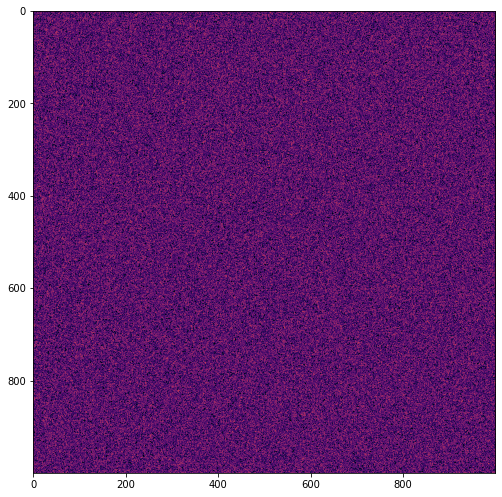

In [264]:
nparticle=1000000
ngrid=1000
ics="uniform"
periodic=True
parts=Particles(nparticle,ngrid,periodic=periodic,ics=ics)
parts.initconditions()
parts.get_density()
plot_nbody(parts)

In [265]:
#test uniform ics with periodic mode
nparticle=1000000
ngrid=1000
ics="uniform"
periodic=True
parts=Particles(nparticle,ngrid,periodic=periodic,ics=ics)
parts.initconditions()
dt=0.008
ntakestep=800
make_nbody_gif(parts,ntakestep,dt=dt)

  0%|          | 0/800 [00:00<?, ?it/s]

For 1000000 particles with with time step 0.008 s, taking a step takes 0.04843425750732422 s
For 1000000 particles with with time step 0.008 s, taking a step takes 0.08458518981933594 s
For 1000000 particles with with time step 0.008 s, taking a step takes 0.1214442253112793 s
For 1000000 particles with with time step 0.008 s, taking a step takes 0.15359711647033691 s
For 1000000 particles with with time step 0.008 s, taking a step takes 0.1879720687866211 s


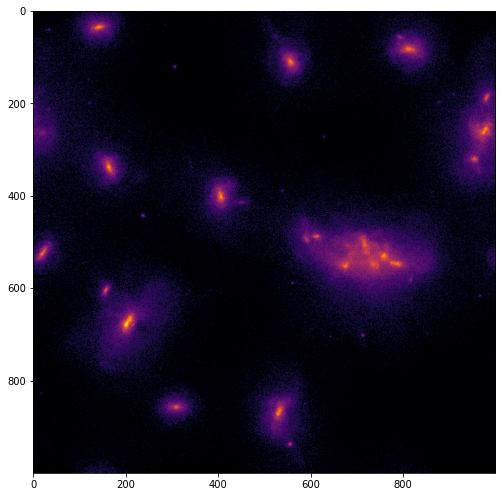

see gif test_uni_per.gif

In [271]:
#test uniform ics with not periodic mode
nparticle=1000000
ngrid=1000
ics="uniform"
periodic=False
parts=Particles(nparticle,ngrid,periodic=periodic,ics=ics)
parts.initconditions()

dt=0.008
ntakestep=600
make_nbody_gif(parts,ntakestep,dt=dt)

  0%|          | 0/600 [00:00<?, ?it/s]

For 1000000 particles with with time step 0.008 s, taking a step takes -0.337054967880249 s


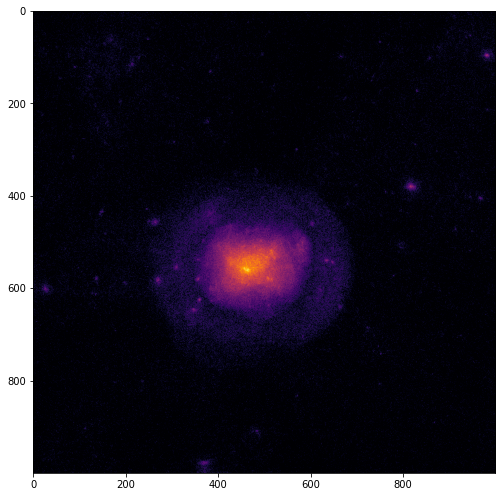

see gif test_uni_nper.gif


In [273]:
#test one gaussian cluster -Periodic
ics="normal"
periodic=True
parts=Particles(nparticle,ngrid,periodic=periodic,ics=ics)
parts.initconditions()
dt=0.008
ntakestep=800
make_nbody_gif(parts,ntakestep,dt=dt)

  0%|          | 0/800 [00:00<?, ?it/s]

For 1000000 particles with with time step 0.008 s, taking a step takes 0.04792213439941406 s


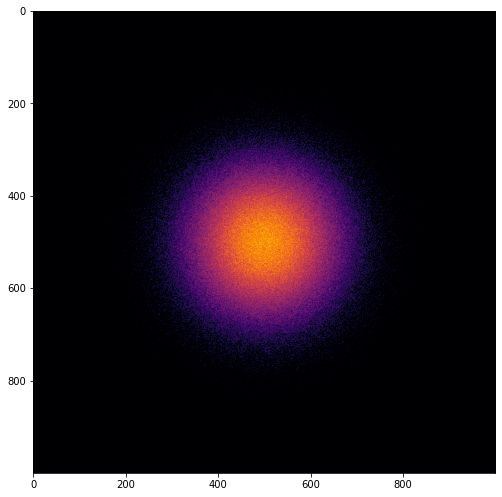

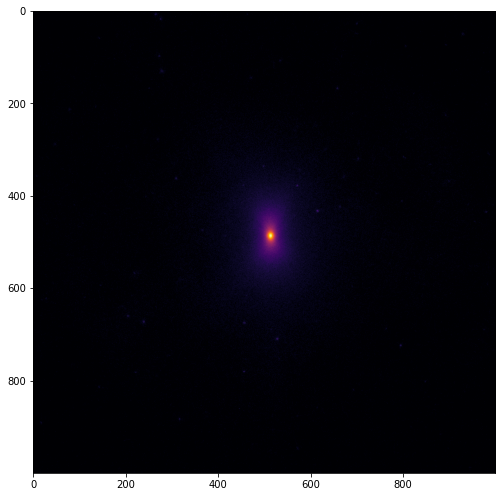

see gif test-norm-per.gif

In [274]:
#test one gaussian cluster -Not Periodic
ics="normal"
periodic=False
parts=Particles(nparticle,ngrid,periodic=periodic,ics=ics)
parts.initconditions()
dt=0.008
ntakestep=600
make_nbody_gif(parts,ntakestep,dt=dt)

  0%|          | 0/600 [00:00<?, ?it/s]

For 1000000 particles with with time step 0.008 s, taking a step takes 0.12477898597717285 s


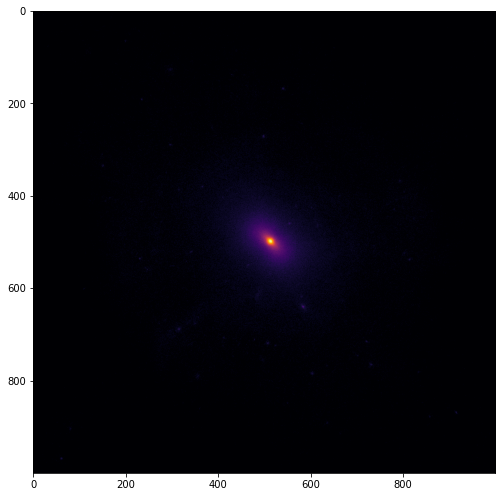

see gif test-norm-nper.gif

If the code is right, if all the particles are positioned at each grid vertex with no velocity and having the same mass, nothing should move. Let's try that.

Text(0, 0.5, 'y positions')

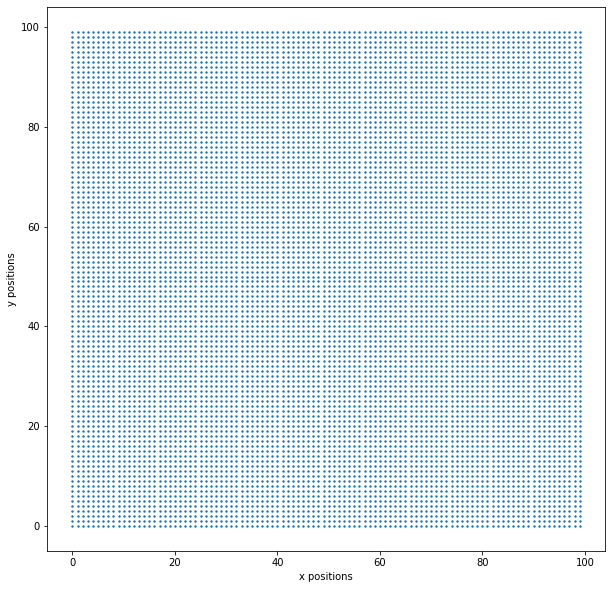

In [255]:
ngrid=100
nparticle=ngrid**2
ics="pergrid"
periodic=True
parts=Particles(nparticle,ngrid,periodic=periodic,ics=ics)
parts.initconditions() #positioned at each grid vertex, with velocity=0
parts.get_density()

fig=plt.figure()
plt.scatter(parts.pos[:,0],parts.pos[:,1],s=2)
fig.set_size_inches([10,10])
plt.xlabel('x positions')
plt.ylabel('y positions')


(array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]))

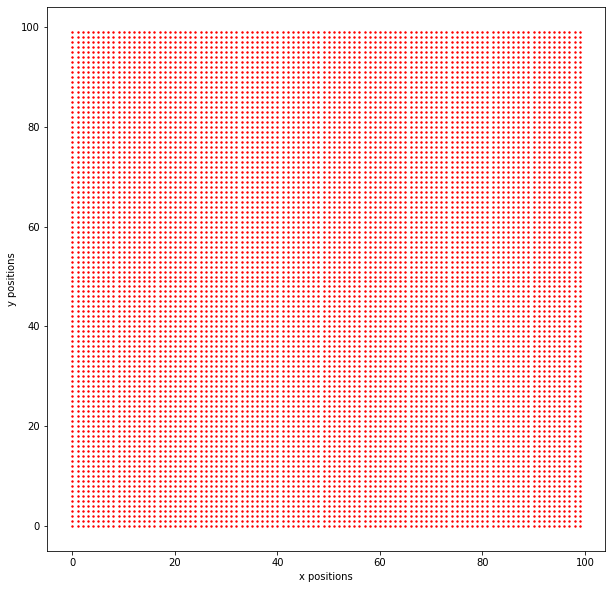

In [261]:
dt=0.05
ntakestep=1000
for i in range(ntakestep):
    parts.take_step(dt)

fig=plt.figure()
plt.scatter(parts.pos[:,0],parts.pos[:,1],s=2,color='red')
fig.set_size_inches([10,10])
plt.xlabel('x positions')
plt.ylabel('y positions')

parts.v, parts.f

We see indeed that the particles did not move, have still no velocity and no force/acceleration so we can be more confident that the code is set up right!

## PART 1 SINGLE PARTICLE STARTING AT REST REMAINS MOTIONLESS


A single particle should remain motionless if its initial speed is 0 since the potential is 0 when the particle is all alone in the univers (so the particle has no acceleration). 

Let's see what happens if the particle has an initial speed in periodic mode. We can choose the $\delta t$ to be greater than what we would normally choose since there should be no force. 

In [279]:
nparticle=1
ngrid=100
ics="uniform"
periodic=True
parts=Particles(nparticle,ngrid,periodic=periodic,ics=ics)
parts.initconditions()
parts.pos[:]=ngrid/2-0.5
parts.v[:,1]=1
dt=1
make_nbody_gif(parts,100,dt)

  0%|          | 0/100 [00:00<?, ?it/s]

For 1 particles with with time step 1 s, taking a step takes 0.002966165542602539 s


So, it loops as expected! see one-per.gif

Check now for v=0 

In [280]:
periodic=True
parts=Particles(nparticle,ngrid,periodic=periodic,ics=ics)
parts.initconditions()
parts.pos[:]=ngrid/2-0.5


make_nbody_gif(parts,101,dt)

initpos=np.ones(2)*ngrid/2-0.5
finalpos=parts.pos[0,:]

initv=np.zeros(2)
finalv=parts.v[0,:]

diff_pos = finalpos-initpos
diff_v = finalv-initv
print("Delta position is {} in x and {} in y".format(f'{diff_pos[0]:.3}',f'{diff_pos[1]:.3}'))
print("Delta velocity is {} in x and {} in y".format(f'{diff_v[0]:.3}',f'{diff_v[1]:.3}'))

  0%|          | 0/101 [00:00<?, ?it/s]

For 1 particles with with time step 1 s, taking a step takes 0.001667022705078125 s
Delta position is -4.83e-12 in x and 1.26e-12 in y
Delta velocity is -2.08e-14 in x and 3.64e-15 in y


These are deltas are insignificant, we can check what the force is to see if it experiences acceleration.

In [281]:
print("The acceleration in x and y is {}, {}".format(f'{parts.f[0,0]:.3}',f'{parts.f[0,1]:.3}'))

The acceleration in x and y is -5.55e-17, 0.0


These are basically 0 in computer world. Also see gif one-constant.gif

## PART TWO: CIRCULAR ORBIT

We need to set up the right initial conditions for two particles. I did that with trials and errors (even though it could be found analytically). I set up the particles at 25 grid cells apart in the y position and put opposite $x$ velocities of 0.136.

In [334]:
nparticle=2
ngrid=100
ics="orbit"
periodic=False
parts=Particles(nparticle,ngrid,periodic=periodic,ics=ics)
parts.initconditions()
dt=0.05
nstep=400
make_nbody_gif(parts,nstep,dt,osamp=100)

  0%|          | 0/400 [00:00<?, ?it/s]

For 2 particles with with time step 0.05 s, taking a step takes 0.0034410953521728516 s


With sensible initial conditions, we see that a pair of particles placed in a circular orbit continue to orbit each other for some reasonable length of time!

In [336]:
f_orbit=parts.f
f_orbit

array([[ 0.00021771, -0.00162896],
       [-0.00015755,  0.00163883]])

We see that the forces are ~equal and opposite which is what we expect for a circular orbit!

Also see gif orbit.gif

## PART THREE: TRACKING THE TOTAL ENERGY

We want to track down the energy of the simulation starting from uniform random positions conditions. (The energy function is described in one of the text block above). 

In [406]:
nparticle=1000000
ngrid=1000
ics="uniform"
periodic=True
parts=Particles(nparticle,ngrid,periodic=periodic,ics=ics)
parts.initconditions()
keep_seed=parts.pos.copy()

In [407]:
#Looping and checking the energy only
#periodic mode


dt=0.008
ntakestep=20000
kins_periodic=np.zeros(ntakestep)
pots_periodic=np.zeros(ntakestep)
energy_periodic=np.zeros(ntakestep)
for i in tqdm(range(ntakestep)):
    parts.take_step(dt)
    parts.get_energy()
    kins_periodic[i]=parts.kin
    pots_periodic[i]=parts.pot
    energy_periodic[i]=parts.energy
    


  0%|          | 0/20000 [00:00<?, ?it/s]

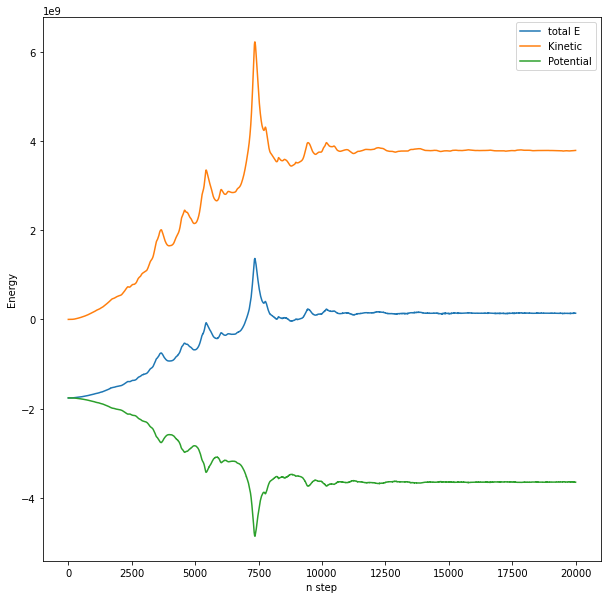

In [417]:
fig=plt.figure()

plt.plot(energy_periodic,label='total E')
plt.plot(kins_periodic,label='Kinetic')
plt.plot(pots_periodic,label='Potential')

plt.xlabel('n step')
plt.ylabel('Energy')
plt.legend()
fig.set_size_inches([10,10])
plt.savefig('LEAPFROG-energy')

So we see that after some transcient the energy seems to stabilize!

In [436]:
#non periodic mode
periodic=False
parts=Particles(nparticle,ngrid,periodic=periodic,ics=ics)
parts.initconditions()
parts.pos[:] = keep_seed.copy()
parts.v[:]=0
parts.f[:]=0

dt=0.008
ntakestep=20000
kins_nonperiodic=np.zeros(ntakestep)
pots_nonperiodic=np.zeros(ntakestep)
energy_nonperiodic=np.zeros(ntakestep)

for i in tqdm(range(ntakestep)):
    parts.take_step(dt)
    parts.get_energy()
    kins_nonperiodic[i]=parts.kin
    pots_nonperiodic[i]=parts.pot
    energy_nonperiodic[i]=parts.energy


  0%|          | 0/20000 [00:00<?, ?it/s]

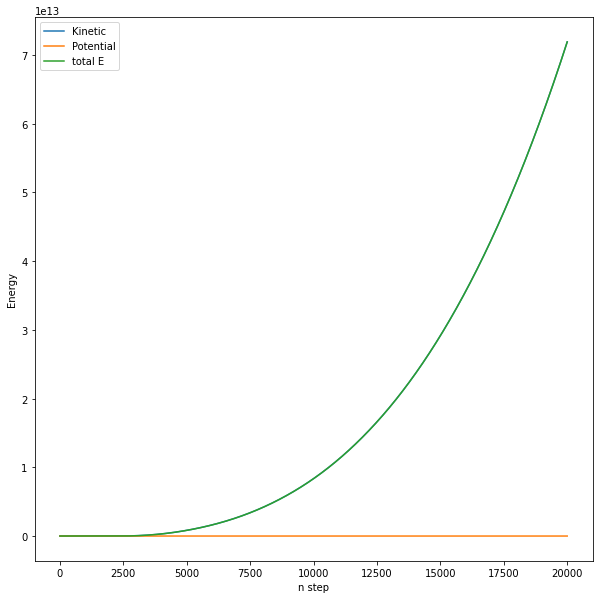

In [437]:
fig=plt.figure()

plt.plot(kins_nonperiodic,label='Kinetic')
plt.plot(pots_nonperiodic,label='Potential')
plt.plot(energy_nonperiodic,label='total E')


plt.xlabel('n step')
plt.ylabel('Energy')
plt.legend()
fig.set_size_inches([10,10])

We observe that energy is not exactly well conserved in both cases but is certainly not conserved for the non-periodic mode (NP). This is expected since for NP (but whether this energy shape is expected I am not sure), we set masses to 0 for the particles that go outside of the grid so obviously, by "losing" some particles, we do not conserve energy.

## PART 4: RK4 INTEGRATOR

We can use the RK4 integrator to have better accuracy when updating the system. The RK4 consists of taking trial steps to get better accuracy:

We want to take trial steps in positions and velocities, by computing trial velocities and forces (the v's and f's trial steps stacked in an array represent the k's in RK4). So we have our best estimates of v's and f's as:

$\left[v_0,v_1,...v_n,f_0,f_1,...f_n\right]=\frac{k_1+2k_2+2k_3+k_4}{6}$

and we use those values to make the update as:

$x_{new}=x_{prec} + v_{RK4}dt$

$v_{new}=v_{prec} + a_{RK4}dt$

We want to compare how the energy conservation compares between RK4 and leapfrog. Since RK4 makes 4 function calls to compute the forces, we want to take 4 times more step with leapfrog with a dt 4 times smaller. We also only want to test with the periodic mode since we know that energy is not conserved in the non-periodic mode.

Let's first test if the code with RK4 works well (in periodic and non-periodic)

In [374]:
#periodic
nparticle=1000000
ngrid=1000
ics="uniform"
periodic=True
method="rk4"
parts=Particles(nparticle,ngrid,periodic=periodic,ics=ics,method=method)
parts.initconditions()


dt=0.08
ntakestep=200
parts.take_step(dt)
make_nbody_gif(parts,ntakestep,dt)

  0%|          | 0/200 [00:00<?, ?it/s]

For 1000000 particles with with time step 0.08 s, taking a step takes 0.2278609275817871 s


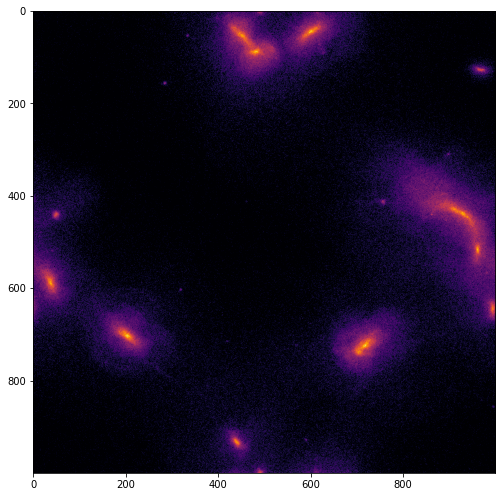

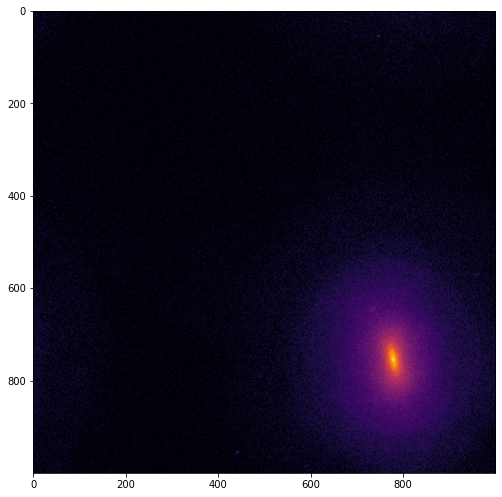

see gif rk4-per.gif

In [435]:
#not periodic
nparticle=1000000
ngrid=1000
ics="uniform"
method="rk4"
periodic=False

parts=Particles(nparticle,ngrid,periodic=periodic,ics=ics,method=method)
parts.initconditions()

dt=0.08
ntakestep=200
parts.take_step(dt)
make_nbody_gif(parts,ntakestep,dt)

  0%|          | 0/200 [00:00<?, ?it/s]

For 1000000 particles with with time step 0.08 s, taking a step takes 0.48299193382263184 s


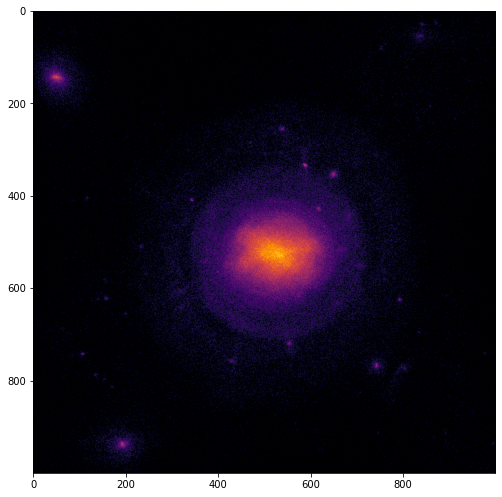

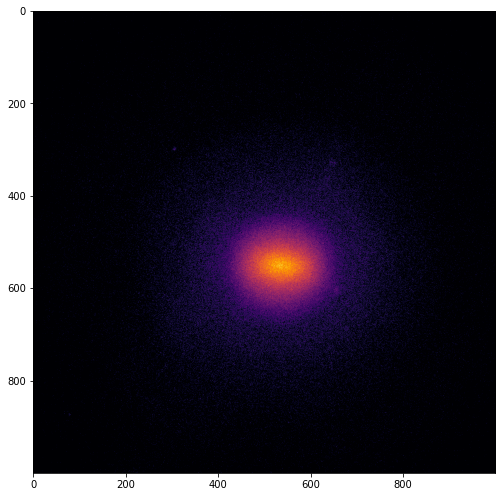

see rk4-nper.gif

Now we can look at the energy conservation for RK4

We want to compare energy conservation for same number of function calls between rk4 and leapfrog. Leapfrog calls get grad once per step and rk4 calls get grad 4 times per step --> take 20000 steps using leap frog and 5000 steps using rk4. We also want a step four times bigger for RK4 than for leap frog.

In [409]:
#Looping and checking the energy only
#periodic mode

nparticle=1000000
ngrid=1000
periodic=True
method="rk4"
parts=Particles(nparticle,ngrid,periodic=periodic,ics=ics,method=method)
parts.initconditions()
parts.pos[:]=keep_seed.copy()
parts.v[:]=0
parts.f[:]=0

dt=0.032
ntakestep=5000
kins_periodic_rk4=np.zeros(ntakestep)
pots_periodic_rk4=np.zeros(ntakestep)
energy_periodic_rk4=np.zeros(ntakestep)
for i in tqdm(range(ntakestep)):
    parts.take_step(dt)
    kins_periodic_rk4[i]=parts.kin
    pots_periodic_rk4[i]=parts.pot
    energy_periodic_rk4[i]=parts.energy
    


  0%|          | 0/5000 [00:00<?, ?it/s]

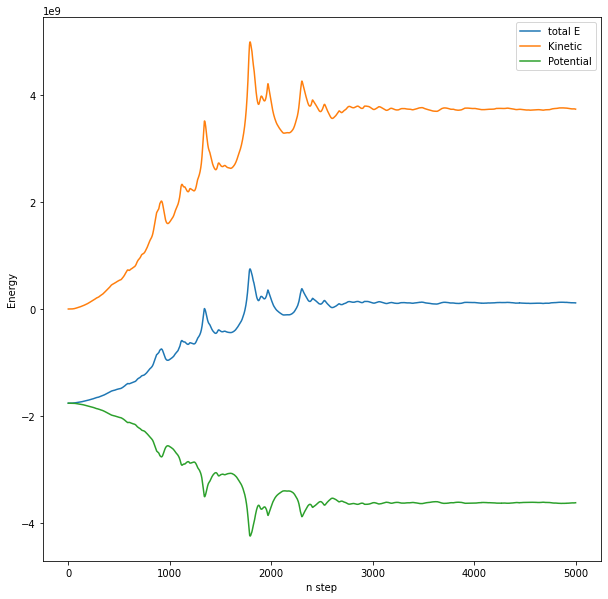

In [415]:
fig=plt.figure()

plt.plot(energy_periodic_rk4,label='total E')
plt.plot(kins_periodic_rk4,label='Kinetic')
plt.plot(pots_periodic_rk4,label='Potential')


plt.xlabel('n step')
plt.ylabel('Energy')
plt.legend()
fig.set_size_inches([10,10])
plt.savefig('RK4-energy')


The energy converged for the RK4 periodic mode! We can now compare the two:

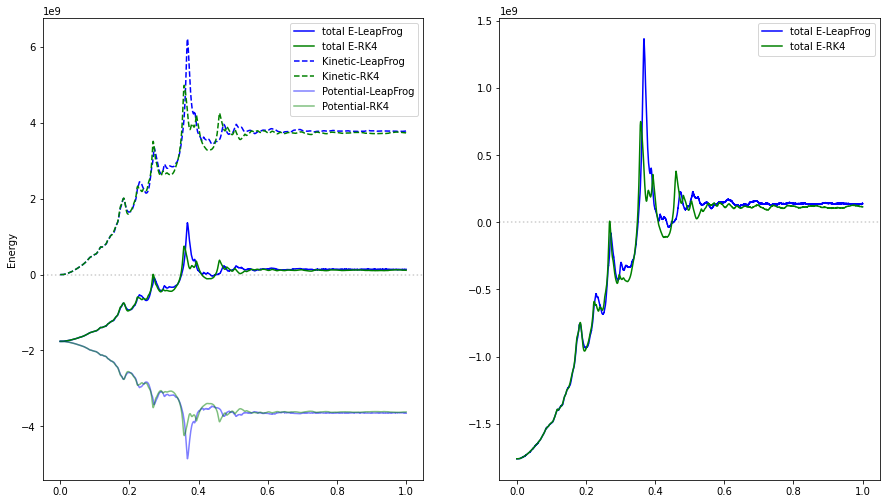

In [434]:
x_rk4=np.linspace(0,1,5000)
x_leapfrog=np.linspace(0,1,20000)
fig,axs=plt.subplots(1,2)

axs[0].plot(x_leapfrog,energy_periodic,label='total E-LeapFrog',color='blue',)
axs[0].plot(x_rk4,energy_periodic_rk4,label='total E-RK4',color='green')
axs[0].axhline(0,linestyle=':',color='k',alpha=0.2)

axs[0].plot(x_leapfrog,kins_periodic,label='Kinetic-LeapFrog',color='blue',linestyle='--')
axs[0].plot(x_rk4,kins_periodic_rk4,label='Kinetic-RK4',color='green',linestyle='--')

axs[0].plot(x_leapfrog,pots_periodic,label='Potential-LeapFrog',color='blue',alpha=0.5)
axs[0].plot(x_rk4,pots_periodic_rk4,label='Potential-RK4',color='green',alpha=0.5)

axs[0].set_ylabel('Energy')
axs[0].legend()

axs[1].plot(x_leapfrog,energy_periodic,label='total E-LeapFrog',color='blue',)
axs[1].plot(x_rk4,energy_periodic_rk4,label='total E-RK4',color='green')
axs[1].axhline(0,linestyle=':',color='k',alpha=0.2)
axs[1].legend()

fig.set_size_inches([15,8.5])
plt.savefig('RK4-energy')

We can see that both methods have converged at some final value for the energy. For leapfrog, this took 20,000 steps withd dt=0.008 and for RK4 5,000 steps with dt=0.032. With these information, I think we can say that RK4 preserved energy better as for a $\delta t$ four times bigger than that leapfrog, and with 4 times less steps, RK4 and leapfrog show similar energy conservation plots. So, RK4 would be more effective at preserving energy for bigger time steps (and naturally smaller steps size too). 